In [11]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from ilan_src.models import *
import numpy as np
import matplotlib.pyplot as plt


In [2]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 124372), started 3 days, 3:03:59 ago. (Use '!kill 124372' to kill it.)

# MNIST

In [13]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMG_SIZE = 64
CHANNELS_IMG = 1
NOISE_SHAPE = (100, 1, 1)
NUM_EPOCHS = 30
FEATURES_CRITIC = 32 #64
FEATURES_GEN = 32 # 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
NUM_CLASSES = 10
GEN_EMBEDDING = 100

trans = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=trans, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

trainer = pl.Trainer(gpus = 1)
model = WGANGP(Generator, Discriminator, NOISE_SHAPE, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING, FEATURES_CRITIC, cond_idx=1, real_idx=0)

trainer.fit(model, loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params
---------------------------------------
0 | gen  | Generator     | 4.4 M 
1 | disc | Discriminator | 735 K 
---------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.520    Total estimated model params size (MB)


Epoch 0:   7%|▋         | 62/938 [00:11<02:47,  5.23it/s, loss=-36.9, v_num=13, discriminator_loss_step=-56.3, generator_loss_step=32.50]

/home/ilan/.conda/envs/ilan/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


# NWP-DownScaling

In [3]:
import xarray as xr
import numpy as np
from src.dataloader import *
from src.utils import *

## Data

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='train',
    pure_sr_ratio=8, 
    tp_log=0.01
)

/home/ilan/.conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='valid',
    mins=ds_train.mins,
    maxs=ds_train.maxs,
    pure_sr_ratio=8,
    tp_log= 0.01
)

/home/ilan/.conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [8]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, sampler=sampler_train, num_workers=6)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=16, sampler=sampler_valid, num_workers=6)

In [9]:
len(ds_train), len(dl_train)

(20988, 1312)

In [10]:
import pickle
pickle.dump(dl_train, open("./dataset/trainloader_pure_sr.pkl", "wb"))
pickle.dump(dl_valid, open("./dataset/validloader_pure_sr.pkl", "wb"))

## WGAN-GP

In [71]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from ilan_src.models import *
import pickle

dl_train = pickle.load(open("./dataset/trainloader_single_forecast_only.pkl", "rb"))

LEARNING_RATE = 1e-4
IMG_SIZE = 128
CHANNELS_IMG = 1
NOISE_SHAPE = (1, 16, 16)
FEATURES_CRITIC = 32 #64
FEATURES_GEN = 32 # 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
NUM_CLASSES = 10
GEN_EMBEDDING = 10

trainer = pl.Trainer(gpus = 1)
model = WGANGP(DSGenerator, DSDiscriminator, NOISE_SHAPE, CHANNELS_IMG, 
               FEATURES_GEN, NUM_CLASSES, IMG_SIZE, 
               GEN_EMBEDDING, FEATURES_CRITIC, lr = LEARNING_RATE)

trainer.fit(model, dl_train)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params
-----------------------------------------
0 | gen  | DSGenerator     | 2.6 M 
1 | disc | DSDiscriminator | 4.0 M 
-----------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.427    Total estimated model params size (MB)


Epoch 47:  77%|███████▋  | 1004/1312 [11:03<03:23,  1.51it/s, loss=5.45, v_num=38, discriminator_loss_step=-3.42, generator_loss_step=87.30, discriminator_loss_epoch=-10.3, generator_loss_epoch=87.10]   

In [72]:
pickle.dump(model, open("./models/model-wgan-gp-sinlge-forecast-version-38.pkl", "wb"))

In [7]:
def plot_sample(noise, cond, target, gen, k=1):
    with torch.no_grad():
        preds = gen(cond, noise).detach().cpu().numpy()
    
    for i in range(k):
        lr = cond[i, 0].detach().cpu().numpy()
        hr = target[i, 0].detach().cpu().numpy()
        pred = preds[i, 0]
#         print(pred)

        mn = np.min([np.min(hr), np.min(pred)])
        mx = np.max([np.max(hr), np.max(pred)])

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        im = ax1.imshow(lr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
        plt.colorbar(im, ax=ax1, shrink=0.7)
        im = ax2.imshow(pred, vmin=mn, vmax=mx, cmap='gist_ncar_r')
        plt.colorbar(im, ax=ax2, shrink=0.7)
        im = ax3.imshow(hr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
        plt.colorbar(im, ax=ax3, shrink=0.7)
        plt.show()  

In [8]:
def plot_samples_per_input(cond, target, gen, k=1, samples = 3):
    fig, axs = plt.subplots(k, samples+2, figsize=(15, k*5))
    gen_images = np.zeros((k,samples+2,128,128))
    with torch.no_grad():    
        for i in range(4):
            noise = torch.randn(cond.shape[0], 1, cond.shape[2], cond.shape[3])
            pred = gen(cond, noise).detach().cpu().numpy()
            for j in range(k):
                gen_images[j,i,:,:] = pred[j, 0] 

    for j in range(k):
        lr = cond[j, 0].detach().cpu().numpy()
        hr = target[j, 0].detach().cpu().numpy()
        mn = np.min([np.min(hr), np.min(pred), np.min(gen_images[j,i,:,:])])
        mx = np.max([np.max(hr), np.max(pred), np.max(gen_images[j,i,:,:])])
        im = axs[j,0].imshow(lr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        im = axs[j,1].imshow(hr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        for i in range(samples):
            im = axs[j,i+2].imshow(gen_images[j,i,:,:], vmin=mn, vmax=mx, cmap='gist_ncar_r')
#             plt.colorbar(im, ax=axs[j,i], shrink=0.7)
    plt.show()  

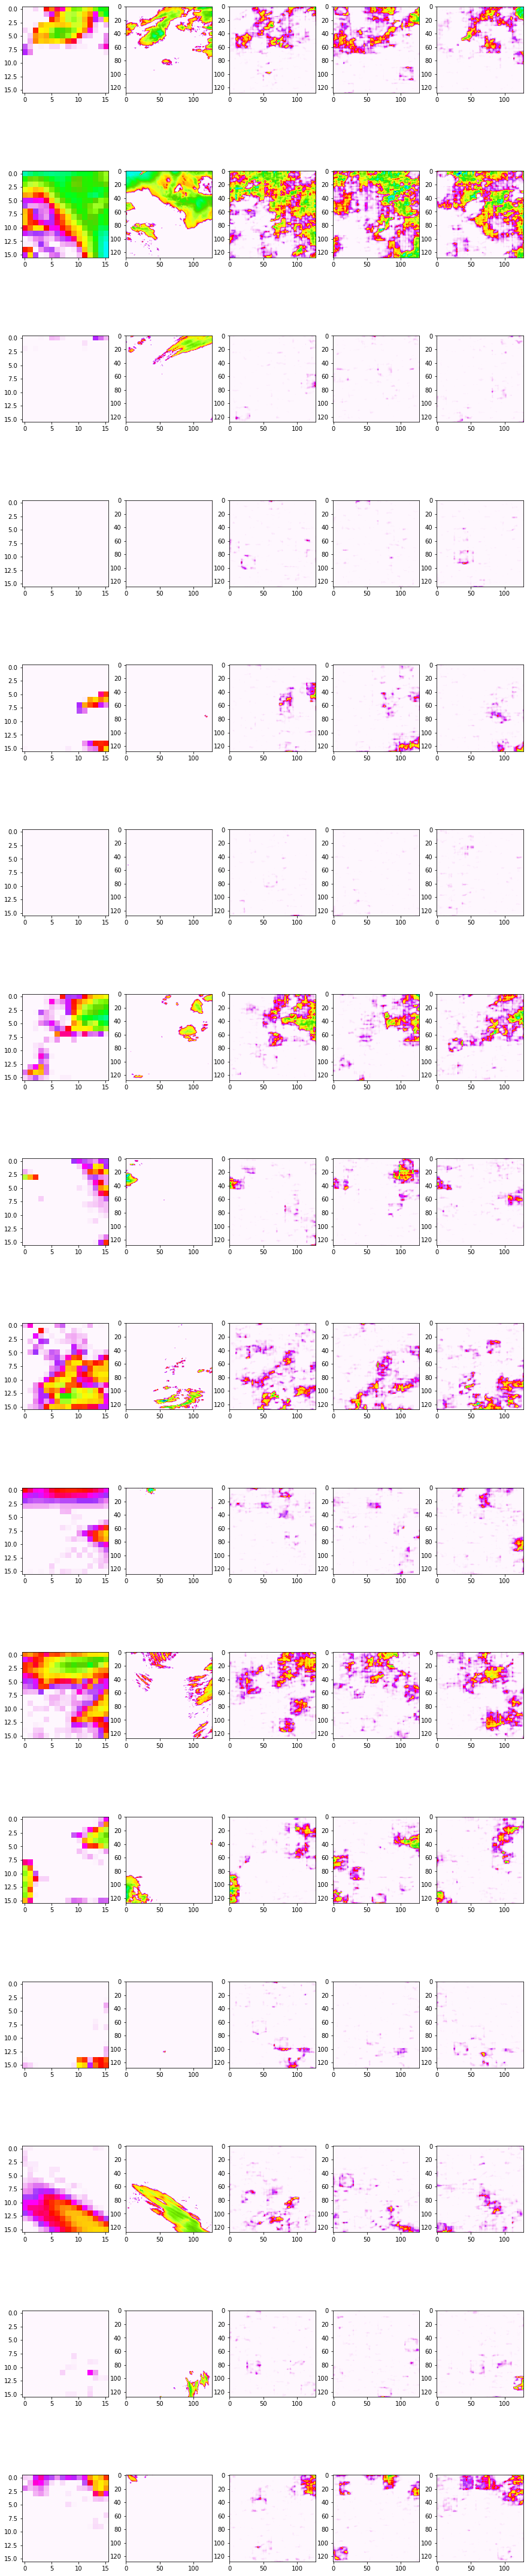

In [77]:
x_sample, y_sample = next(iter(dl_valid))
# noise = torch.randn(x_sample.shape[0], *model.noise_shape)
# plot_sample(noise, x_sample, y_sample, model.gen, k=16)
plot_samples_per_input(x_sample, y_sample, model.gen, k=16)

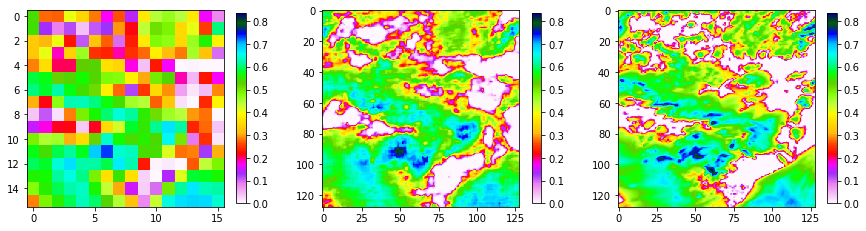

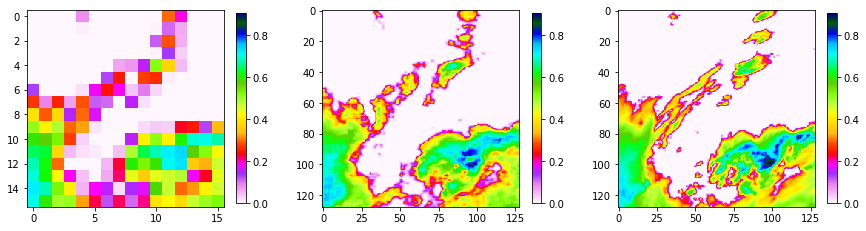

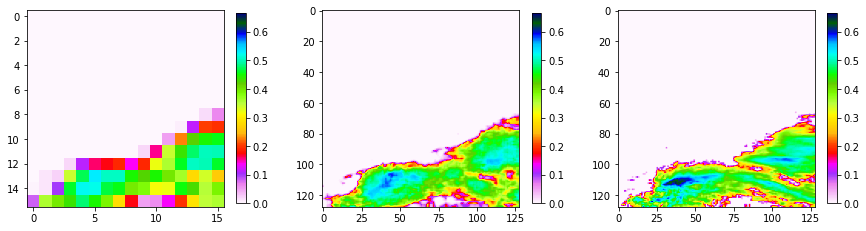

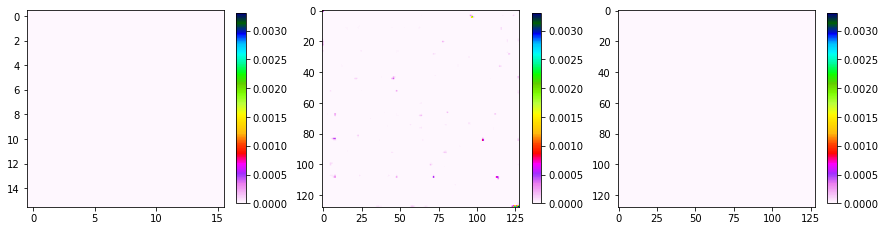

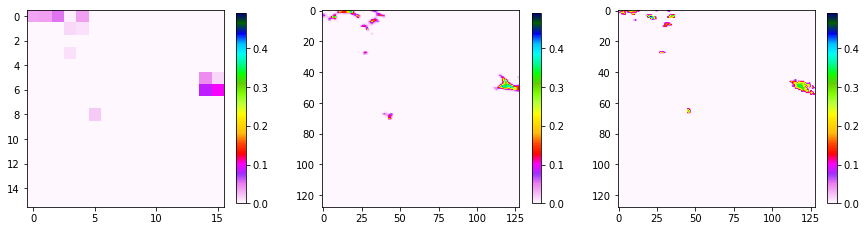

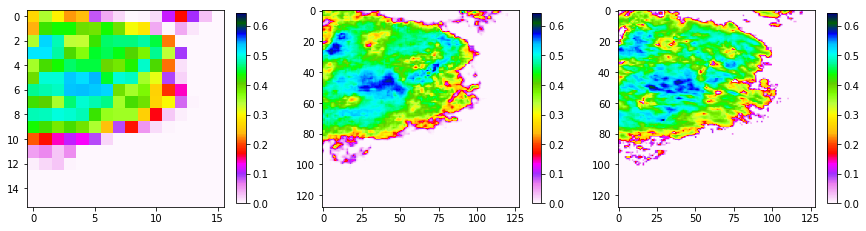

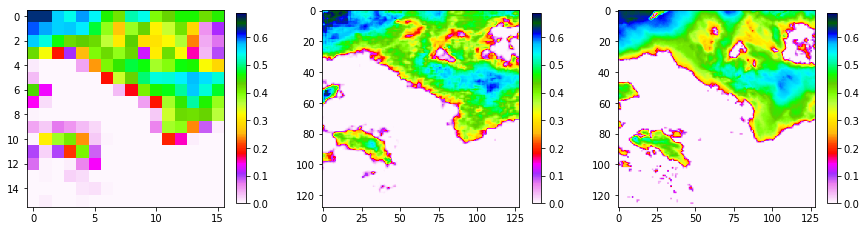

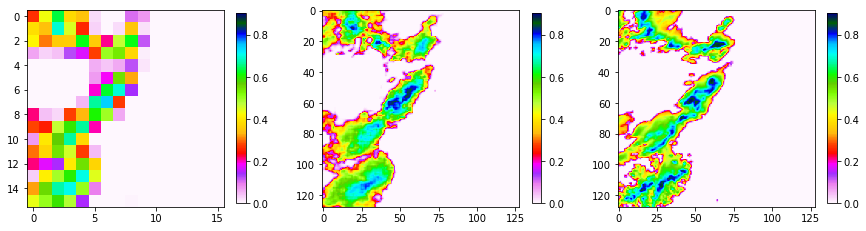

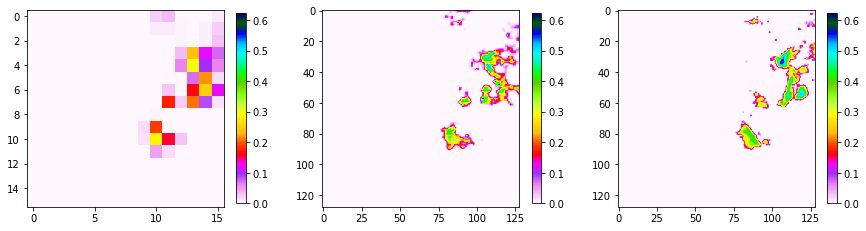

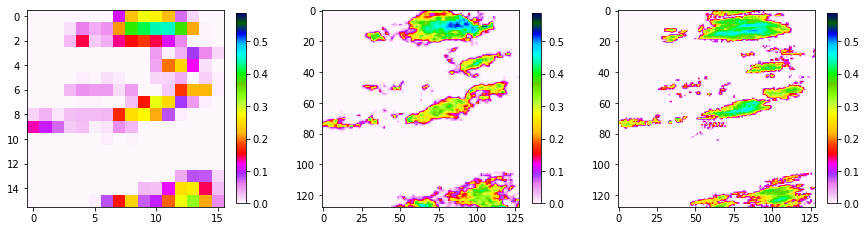

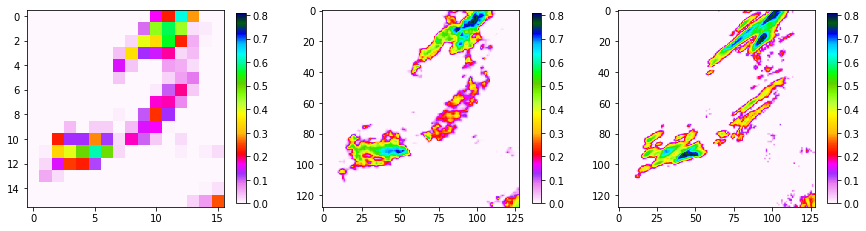

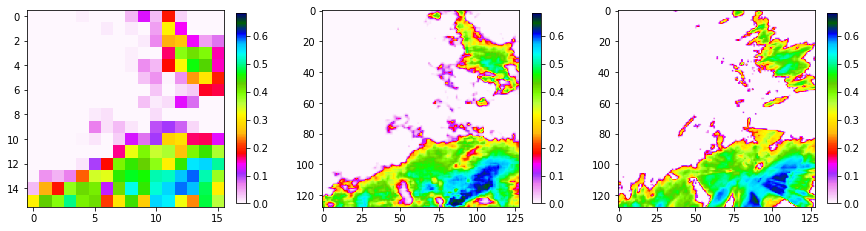

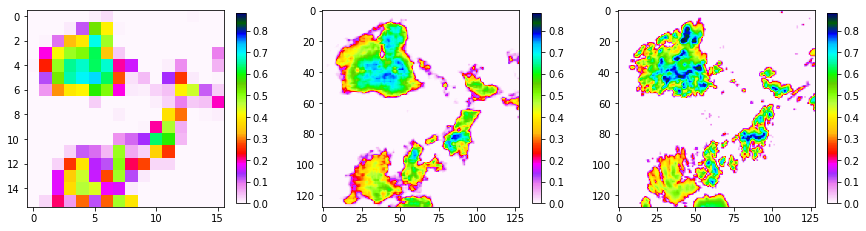

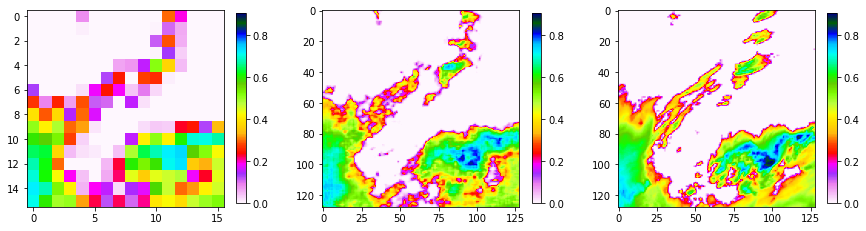

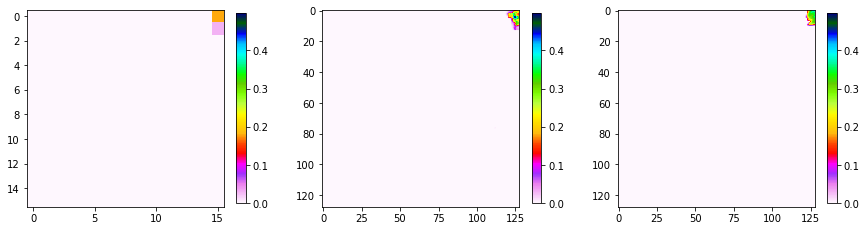

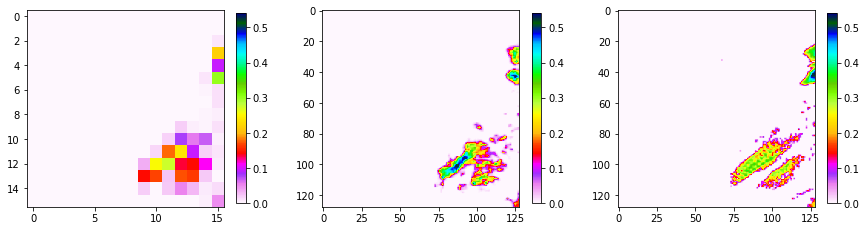

In [23]:
x_val_sample, y_val_sample = next(iter(dl_valid))
noise = torch.randn(x_val_sample.shape[0], *model.noise_shape)
plot_sample(noise, x_val_sample, y_val_sample, model.gen, k=16)

## LeinGan

In [ ]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from ilan_src.models import *
import pickle

dl_train = pickle.load(open("./dataset/trainloader_single_forecast_only.pkl", "rb"))

LEARNING_RATE = 1e-4
IMG_SIZE = 128
CHANNELS_IMG = 1
NOISE_SHAPE = (1, 16, 16)
NUM_EPOCHS = 30
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
NUM_CLASSES = 10
GEN_EMBEDDING = 10

trainer = pl.Trainer(gpus = 1)
model = LeinGANGP(LeinGen, LeinDisc, 
                  NOISE_SHAPE, CHANNELS_IMG, 
                  IMG_SIZE, GEN_EMBEDDING, 
                  lr = LEARNING_RATE,
                  lambda_gp=LAMBDA_GP)

trainer.fit(model, dl_train)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | gen  | LeinGen  | 4.2 M 
1 | disc | LeinDisc | 5.6 M 
----------------------------------
9.8 M     Trainable params
0         Non-trainable params
9.8 M     Total params
39.008    Total estimated model params size (MB)


Epoch 6:  31%|███       | 402/1312 [04:20<09:49,  1.54it/s, loss=33.9, v_num=88, discriminator_loss_step=0.577, generator_loss_step=131.0, discriminator_loss_epoch=-5.03, generator_loss_epoch=237.0]   

In [2]:
pickle.dump(model, open("./models/model-leingan-single-forecast-version-88.pkl", "wb"))

In [5]:
dl_valid = pickle.load(open("./dataset/validloader_pure_sr.pkl", "rb"))

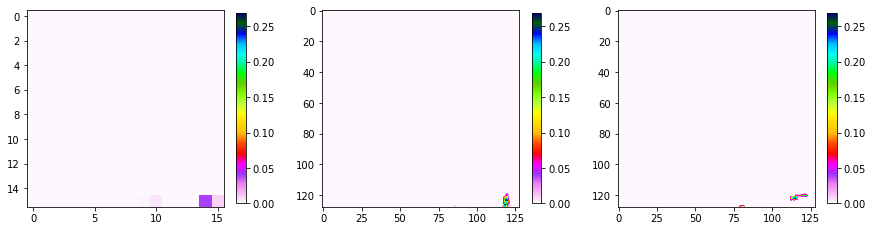

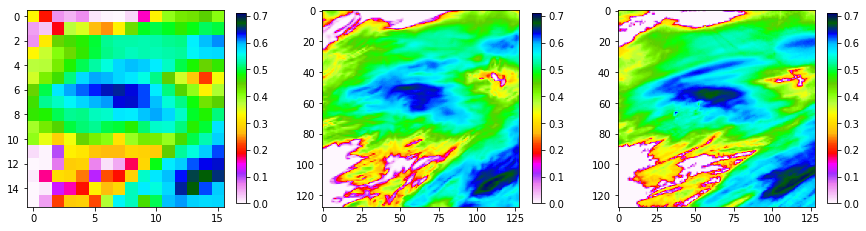

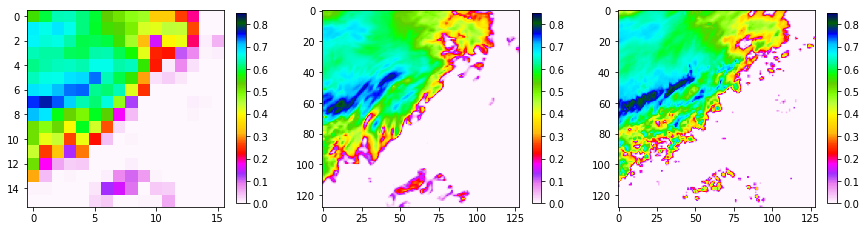

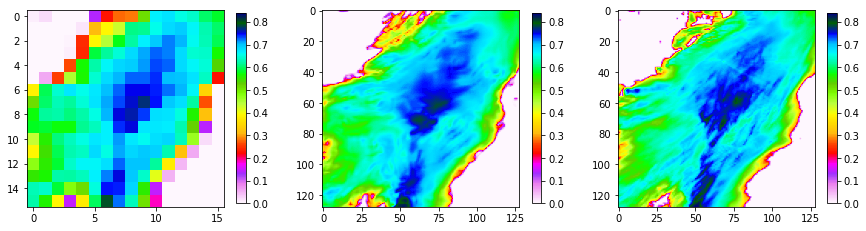

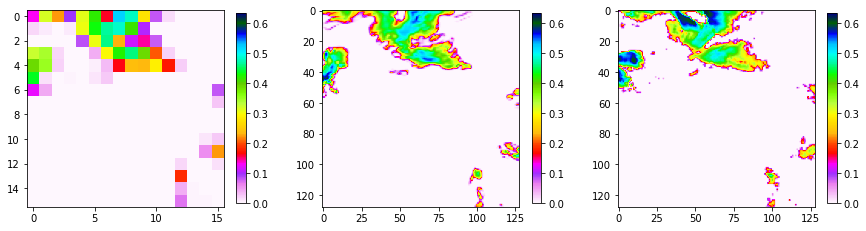

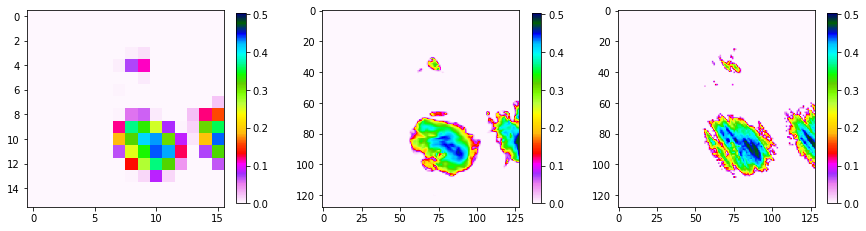

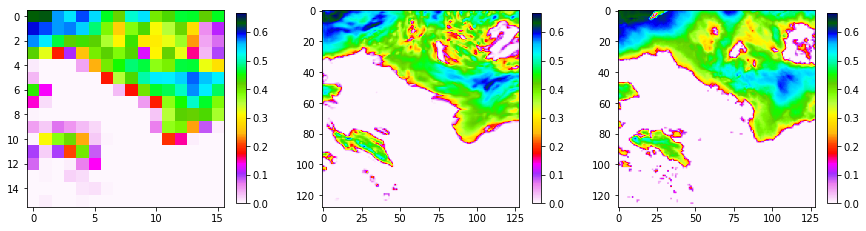

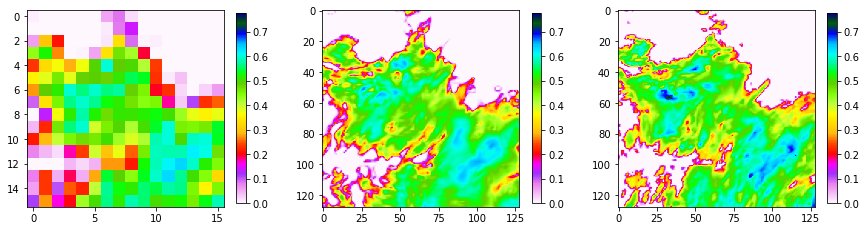

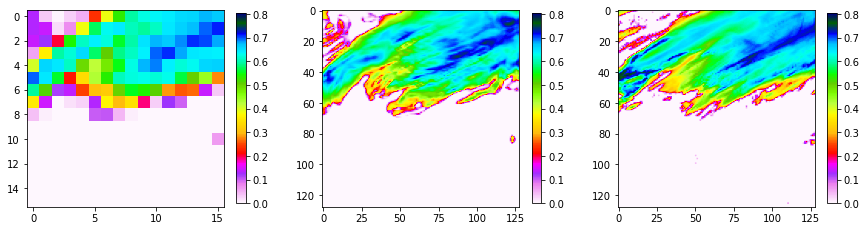

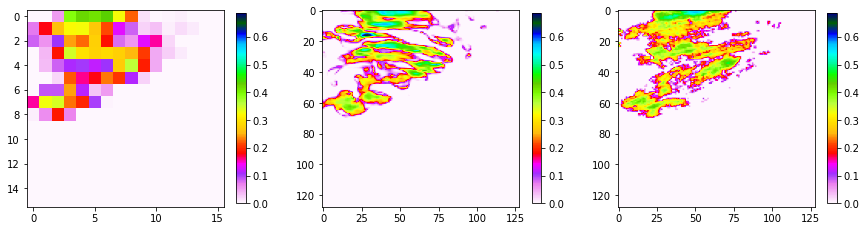

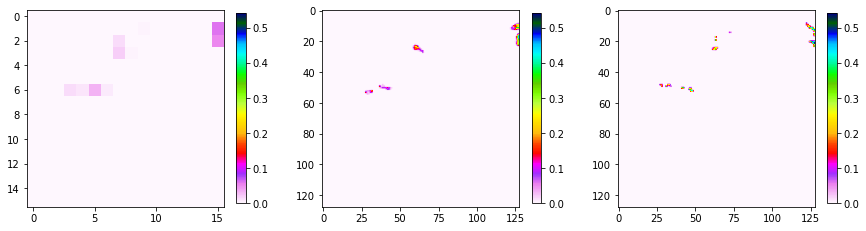

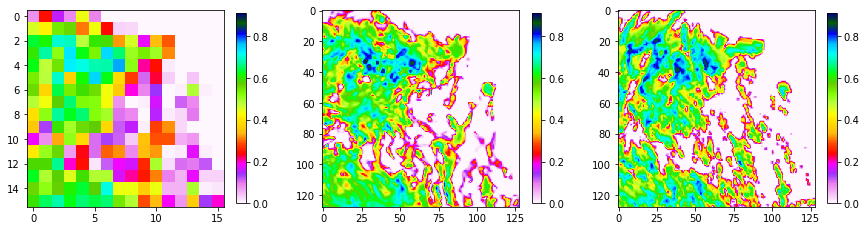

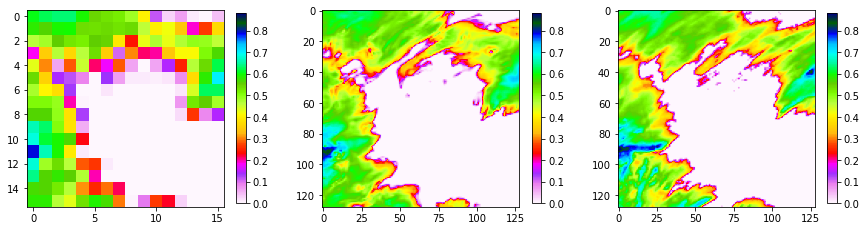

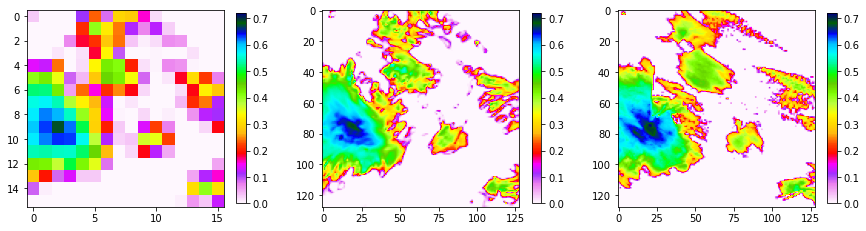

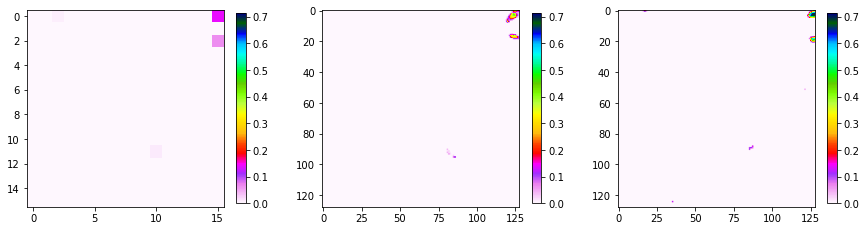

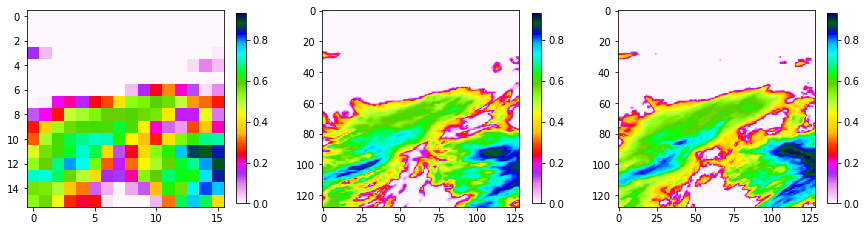

In [12]:
x_val_sample, y_val_sample = next(iter(dl_valid))
noise = torch.randn(x_val_sample.shape[0], *model.noise_shape)
plot_sample(noise, x_val_sample, y_val_sample, model.gen, k=16)

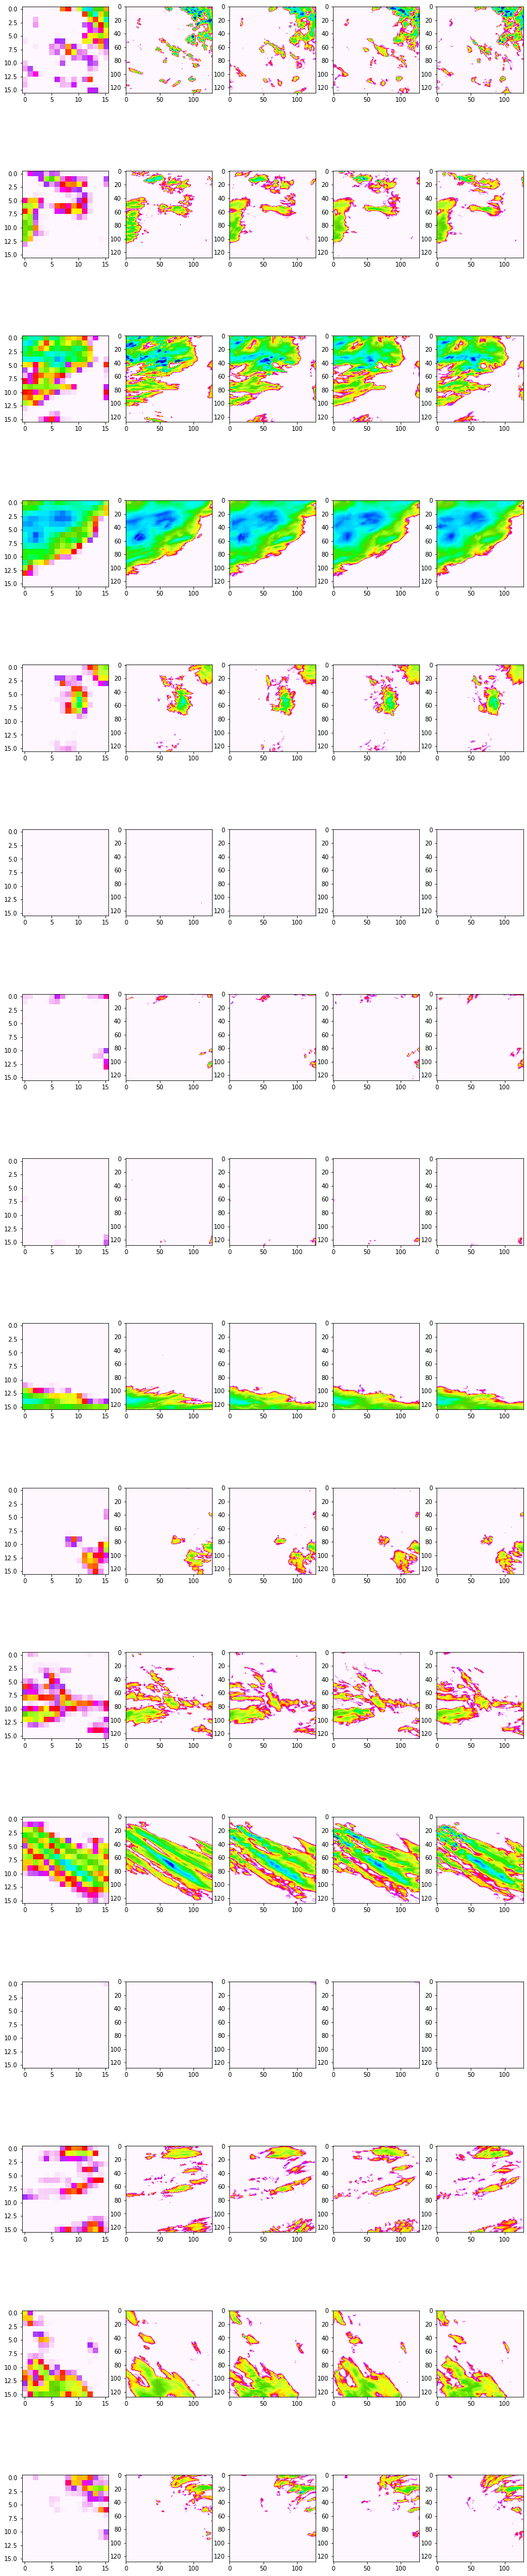

In [14]:
x_sample, y_sample = next(iter(dl_valid))
# noise = torch.randn(x_sample.shape[0], *model.noise_shape)
# plot_sample(noise, x_sample, y_sample, model.gen, k=16)
plot_samples_per_input(x_sample, y_sample, model.gen, k=16)

In [112]:
out = g(x, noise)

In [113]:
out.shape

torch.Size([16, 1, 128, 128])

torch.Size([16, 1])

In [90]:
hin = 32
s = 1
p = 1
k = 4
d = 1

h = (hin-1)*s -2*p + d*(k-1) + 1
h

33

In [87]:
hin = 16
s = 2
p = 0
k = 1
d = 1

h = (hin-1)*s -2*p + d*(k-1) + 1
h

31